In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import datetime
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# Any results you write to the current directory are saved as output.

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
# Importing necessary libraries
import glob
import pickle
import cv2
from sklearn.model_selection import train_test_split
import keras
from keras import backend as k
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation, Dropout
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

In [ ]:
data_dir=os.path.join('..','input/numta')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

In [ ]:
paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

In [ ]:
path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [ ]:
def get_key(path):
    '''yields the key of an image from the filepath
    Args:
        path: The full path directory of an image
    Returns:
        key: The identifier of the image'''
    key=path.split(sep=os.sep)[-1]
    return key

In [ ]:
def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_COLOR) # images loaded in color (BGR)
        #img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # cnahging colorspace to GRAY
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
        #X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        thresh = 200
        maxValue = 255
        #th, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
        ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

In [ ]:
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

In [ ]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

In [ ]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

In [ ]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [ ]:
X_tshow_all=X_test_all
X_tshow_all.shape

# reshaping the data to dim - (number of samples, img_height, img_width, no_of_channels)
X_train_all = X_train_all.reshape(-1, 28, 28,1).astype('float32')
X_test_all = X_test_all.reshape(-1, 28, 28,1).astype('float32')

X_train_all.shape

# normalizing the input
X_train_all = X_train_all / 255
X_test_all = X_test_all / 255

In [ ]:
# segregating trainig set and dev set

"""indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)

# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]

# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]"""

X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, y_train_all, test_size = 0.15, random_state=2)



In [ ]:
'''the architecture is quite similar to VGGNet with 2 consecutive convolution layers followed by a poolig layer and repeat the same for 3 times before 
flattening the array and fed it into a fully connected archritecture'''

def my_model(img_size=28, channels=1):
    
    model = Sequential()
    input_shape = (img_size,img_size,channels)
    
    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))    
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model

In [ ]:
model=my_model()
model.summary()

In [ ]:
# saving the architecture and the parameters of the model
path_model='model_filter.h5' # save model at this location after each epoch

In [ ]:
# destroys the current graph and builds a new one
#k.tensorflow_backend.clear_session()

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 30
batch_size = 64
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# destroys the current graph and builds a new one
k.tensorflow_backend.clear_session() 

# create the model
model=my_model()

# set the learning rate
k.set_value(model.optimizer.lr,1e-3) 

# fit the model
final = model.fit(x=X_train, y=Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), shuffle=True, callbacks=[ModelCheckpoint(filepath=path_model), learning_rate_reduction])

In [ ]:
X_sample = X_train_a[:40]
Y_sample = y_train_a[:40]

imshow_group(X=X_sample,y=Y_sample,phase='processed')

In [ ]:
# get predictions for all the test data
predictions=model.predict(X_test_all)

In [ ]:
predictions[1]

In [ ]:
X_sample = X_test_a[:40]

imshow_group(X=X_sample, y=None, y_pred=predictions, phase='prediction')

In [ ]:
# making prediction on a subset of data
dev_predict = model.predict(X_train_a.reshape(-1, 28, 28,1).astype('float32'))

In [ ]:
# get the indice of the images which were incorrectly labeled
incorrect_ind=[]
for i,pred in enumerate(predictions):
    if np.argmax(y_train_a[i])!=np.argmax(pred):
        incorrect_ind.append(i)

In [ ]:
# let's observe some samples of the incorrectly classified data
X_inc=X_train_a[incorrect_ind[:40]]
y_inc=predictions[incorrect_ind[:40]]
y_true=y_train_a[incorrect_ind[:40]]

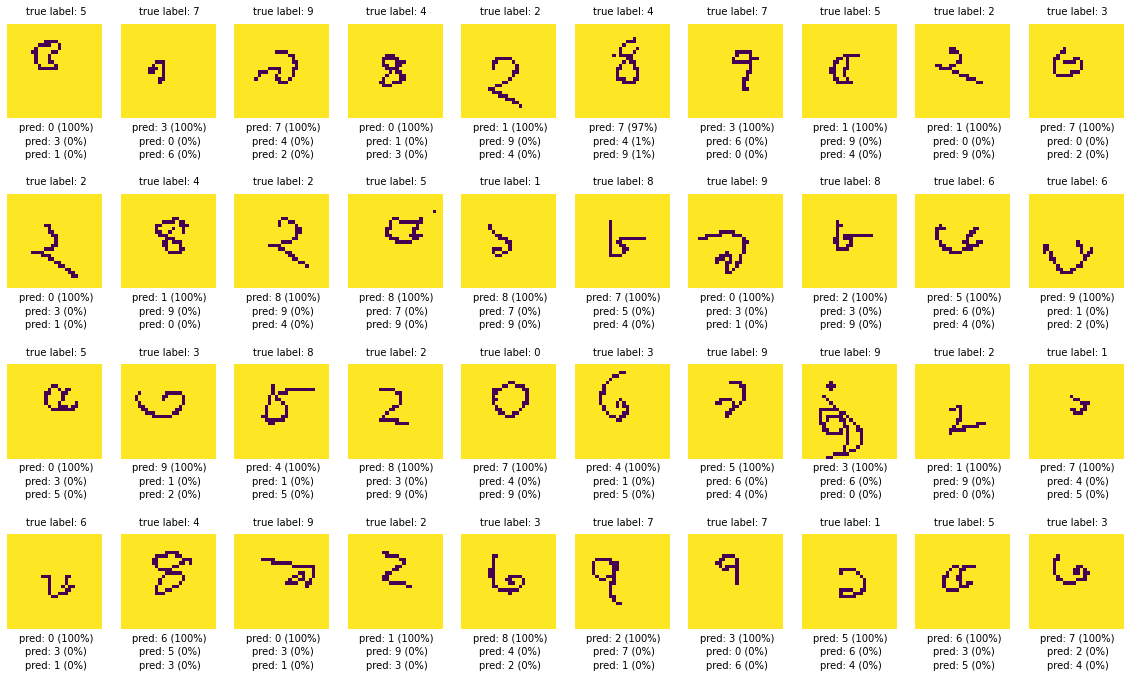

In [45]:
imshow_group(X=X_inc,y=y_true,y_pred=y_inc, phase='prediction')

# **Submission**

In [52]:
# select the index with the maximum probability
results = np.argmax(predictions,axis = 1)

In [46]:
# get the keys of all test images
keys=[get_key(path) for path in paths_test_all]

In [49]:
# get the current time and add it to the submission filename, helps to keep track of submissions
current_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
flname_sub = 'submission_' + current_time + '_'+'.csv' # submission file name
flname_sub

'submission_2020-04-15-18-13_.csv'

In [50]:
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True) 

In [53]:
create_submission(results,keys,flname_sub)

In [ ]:
# Let's load the submission and display it
pd.read_csv(flname_sub)